In [34]:
import numpy as np
import pandas as pd
import random
from tensorflow import keras
from keras.layers import LSTM, Dense, Dropout, GRU, Flatten
from keras.models import Sequential  
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras import models 
import seaborn as sns

In [35]:
# from google.colab import drive
# drive.mount("/content/gdrive")

Read different columns and delete zeros from them

In [36]:
data_train = pd.read_csv('training_dataset.csv')
data1 = np.array(data_train['firewall_rx_bytes']).reshape(-1,1)
data2 = np.array(data_train['dpi_rx_bytes']).reshape(-1,1)
data3 = np.array(data_train['ids_rx_bytes']).reshape(-1,1)
data4 = np.array(data_train['lb_rx_bytes']).reshape(-1,1)

C:\Users\atvk1\AppData\Local\Temp\ipykernel_15784\4187694065.py:1: DtypeWarning: Columns (2,20,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data_train = pd.read_csv('training_dataset.csv')


Normalizatiion

In [37]:
scaler = MinMaxScaler(feature_range=(0,20)) 
data_scaled1 = scaler.fit_transform(data1)
data_scaled2 = scaler.fit_transform(data2)
data_scaled3 = scaler.fit_transform(data3)
data_scaled4 = scaler.fit_transform(data4)


Split train data and test data

In [38]:
train_size1 = int(len(data1)*0.8)
train1 = data_scaled1[0:train_size1,:]
test1 = data_scaled1[train_size1:,:]

train_size2 = int(len(data2)*0.8)
train2 = data_scaled2[0:train_size2,:]
test2 = data_scaled2[train_size2:,:]

train_size3 = int(len(data3)*0.8)
train3 = data_scaled3[0:train_size3,:]
test3 = data_scaled3[train_size3:,:]

train_size4 = int(len(data4)*0.8)
train4 = data_scaled4[0:train_size4,:]
test4 = data_scaled4[train_size4:,:]

Preproccessing data for LSTM models

In [39]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

In [40]:
LOOK_BACK = 4
X1_train, y1_train = create_dataset(train1,LOOK_BACK)
X1_test, y1_test = create_dataset(test1,LOOK_BACK)

X2_train, y2_train = create_dataset(train2, LOOK_BACK)
X2_test, y2_test = create_dataset(test2, LOOK_BACK)

X3_train, y3_train = create_dataset(train3,LOOK_BACK)
X3_test, y3_test = create_dataset(test3,LOOK_BACK)

X4_train, y4_train = create_dataset(train4,LOOK_BACK)
X4_test, y4_test = create_dataset(test4,LOOK_BACK)

Create models(PMs)

In [41]:
def model1(): # FW
    model = Sequential()
    model.add(GRU(48, return_sequences=True, input_shape=(4,1)))
    model.add(GRU(32, activation='tanh',return_sequences=True))
    model.add(GRU(32, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.0005759),loss='mse', metrics='mae')
    return model

In [42]:
def model2(): # DPI
    model = Sequential()
    model.add(GRU(64,return_sequences=True, input_shape=(4,1)))
    model.add(GRU(32, activation='tanh', return_sequences=True))
    model.add(GRU(16, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.0006384),loss='mse', metrics='mae')
    return model

In [43]:
def model3(): # IDS
  model = Sequential()
  # Input layer
  model.add(LSTM(32,return_sequences=True, input_shape=(4,1)))
  # Hidden layer
  model.add(LSTM(48, activation='tanh'))
  # Output layer
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=0.000616),loss='mse', metrics='mae')
  return model

In [44]:
def model4(): # LB
    model = Sequential()
    model.add(GRU(48,return_sequences=True, input_shape=(4,1)))
    model.add(GRU(48, activation='tanh', return_sequences=True))
    model.add(GRU(48, activation='tanh', return_sequences=True))
    model.add(GRU(16, activation='tanh', return_sequences=True))
    model.add(GRU(16, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.000871),loss='mse', metrics='mae')
    return model

In [45]:
def model_SFC(): # SFC  # The structure by keras tuner
  model = Sequential()
  # Input layer
  model.add(LSTM(32,return_sequences=True, input_shape=(4,1)))
  # Hidden layer
  model.add(LSTM(64,return_sequences=True, activation='tanh'))
  model.add(LSTM(48,return_sequences=True, activation='tanh'))
  model.add(LSTM(48,return_sequences=True, activation='tanh'))
  model.add(LSTM(16,activation='tanh'))
  # Output layer
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=0.00021),loss='mse', metrics='mae')
  return model

In [46]:
def model_SFC_GRU(): # SFC  # The structure by keras tuner
  model = Sequential()
  # Input layer
  model.add(GRU(16,return_sequences=True, input_shape=(4,1)))
  
  model.add(GRU(48,return_sequences=True, activation='tanh'))
  model.add(GRU(48, activation='tanh'))
  # Output layer
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=0.0005),loss='mse', metrics='mae')
  return model

In [47]:
model1 = model1()
model2 = model2()
model3 = model3()
model4 = model4()

In [48]:
lstm_SFC = model_SFC()
gru_SFC = model_SFC_GRU()

Fit models

In [49]:
def fit_model(model,X_train,y_train):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
    history = model.fit(X_train, y_train, epochs = 5,  validation_split = 0.2,batch_size = 16, shuffle = False, callbacks = [early_stop], verbose=0)
    return model

In [50]:
# sub1 = fit_model(model1,X1_train,y1_train)
# model1.save("./model1.tf")

In [51]:
# sub2 = fit_model(model2,X2_train,y2_train)
# model2.save("./model2.tf")

In [52]:
# sub3 = fit_model(model3,X3_train,y3_train)
# model3.save("./model3.tf")

In [53]:
# sub4 = fit_model(model4,X4_train,y4_train)
# model4.save("./model4.tf")

In [54]:
sub1 = models.load_model("model1.tf")
sub2 = models.load_model("model2.tf")
sub3 = models.load_model("model3.tf")
sub4 = models.load_model("model4.tf")

Create SFC dataset

In [55]:
# FW, DPI, IDS, LB
start1 = 0
start2 = 0
start3 = 0
start4 = 0
SFC = []
while(start1 <= len(train1) or start2 <= len(train2) or start3 <= len(train3) or start4 <= len(train4)): # until the end of datasets(It should be change later)
    d = random.randint(4,10)
    FW = train1[start1:start1+d]
    start1 = start1+d
    SFC.append(FW)

    d = random.randint(4,10)
    DPI = train2[start2:start2+d]
    start2 = start2+d
    SFC.append(DPI)

    d = random.randint(4,10)
    IDS = train3[start3:start3+d]
    start3 = start3+d
    SFC.append(IDS) 

    d = random.randint(4,10)
    LB = train4[start4:start4+d]
    start4 = start4+d
    SFC.append(LB)

SFC_train = np.concatenate(SFC)
#SFC = np.concatenate(SFC).reshape(1,-1)    

RL

In [56]:
from gym import Env
from gym.spaces import  Discrete, Box
import numpy as np
import time
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from collections import deque

Hyper Parameters

In [57]:
gamma = 0.95 # Discount factor
alpha = 0.001 # Learning rate
epsilon = 1
epsilon_min = 0.0000001
epsilon_decay = 0.998
batch_size = 128
episodes = 15

DQN class

In [58]:
from tabnanny import verbose


class TrafficPrediction:
  def __init__(self,alpha,gamma,epsilon,epsilon_min,epsilon_decay):
    self.action_space = Discrete(4)
    self.nS = 4
    self.nA = self.action_space.n
    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    self.epsilon_decay = epsilon_decay
    self.gamma = gamma
    self.alpha = alpha
    self.loss = []
    self.model = self.build_model()
    self.memory = deque([], maxlen=2500)

  def build_model(self):
    model = Sequential()
    model.add(Dense(24, input_dim=self.nS ,activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(self.nA, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=self.alpha))
    return model

  def action(self, state): #Find action(predictor)
    if np.random.rand() <= self.epsilon: #Explore
        return random.randrange(self.nA)
    action_vals = self.model.predict(state, verbose=0) #Exploit: Use the NN to predict the correct action from this state  
    #print("action selected by model \n")
    return np.argmax(action_vals[0])

  def test_action(self, state): # Exploit (find suitable predictor for test)
    action_vals = self.model.predict(state, verbose=0)
    return np.argmax(action_vals[0])

  def store(self, state, action, reward, nstate):
    # state: seq4, action:single value, reward:single value, nstate:seq4 => Totally store 10 integers values
    # Store observations
    self.memory.append((state,action,reward,nstate))

  def get_reward(self,mse):
    if(mse>=0 and mse<0.1):
        reward = +5
    elif(mse>=0.1 and mse<0.2):
        reward = +4
    elif(mse>=0.2 and mse<0.3):
        reward = +3
    elif(mse>=0.3 and mse<0.4):
        reward = +2
    elif(mse>=0.4 and mse<0.5):
        reward = +1
    elif(mse>=0.5 and mse<0.6):
        reward = 0
    elif(mse>=0.6 and mse<0.7):
        reward = -1
    elif(mse>=0.7 and mse<0.8):
        reward = -2
    elif(mse>=0.8 and mse<0.9):
        reward = -3
    elif(mse>=0.9):
        reward = -4                                
    return reward

  def step(self,action,next_value): # choose a predictor and evaluates its accuracy
    #MSEs = []
    next_value = [next_value]
    if(action == 0):      
      next_predicted_value = sub1.predict(state, verbose=0)
      mse0 = mean_squared_error(next_value,next_predicted_value.flatten())
      reward = self.get_reward(mse0)
      #MSEs.append(mse0)
    elif(action == 1):    
      next_predicted_value = sub2.predict(state, verbose=0)
      mse1 = mean_squared_error(next_value,next_predicted_value.flatten())
      reward = self.get_reward(mse1)
      #MSEs.append(mse1)
    elif(action == 2):
      next_predicted_value = sub3.predict(state, verbose=0)
      mse2 = mean_squared_error(next_value,next_predicted_value.flatten())
      reward = self.get_reward(mse2)
      #MSEs.append(mse2)
    elif(action == 3):
      next_predicted_value = sub4.predict(state, verbose=0)
      mse3 = mean_squared_error(next_value,next_predicted_value.flatten())
      reward = self.get_reward(mse3)
      #MSEs.append(mse3)

    #print("state: ",state)
    nstate = np.array([None]*4).reshape(1,-1) 
    nstate[0,0:3] = state[0,1:4]
    nstate[0,3] = next_value.pop()
    nstate = nstate.astype(float)
    return nstate,reward,next_predicted_value

  def reset(self):
    state = random.sample(range(700,10000),4)
    total_reward = 0
    return self.state

  def expreince_replay(self, batch_size, time): 
    #Execute the expreince replay
    #print("now training is based on experience: ")
    minibatch = random.sample( self.memory, batch_size ) # Randomly sample from memory 
    #print(len(minibatch))    
    x, y = [], []
    np_array = np.array(minibatch)
    st = np.zeros((0,self.nS)) # states
    nst = np.zeros((0,self.nS)) # nStates

    for i in range(len(np_array)): #Creating the state and next state np_array (state is the sequence of the last 4 interval values and next state is the fifth value)
      st = np.append(st, np_array[i,0])  
      nst = np.append(nst, np_array[i,3]) 

    st = np.reshape(st,(batch_size,self.nS))
    nst = np.reshape(nst,(batch_size,self.nS))
    st_predict = self.model.predict(st, verbose=0) 
    nst_predict = self.model.predict(nst, verbose=0)   
    index = 0
    for state, action, reward, nstate in minibatch:
      x.append(state)
      # Predict from state
      nst_action_predict_model = nst_predict[index]
      target = reward + self.gamma * np.argmax(nst_action_predict_model)
      target_f = st_predict[index]
      target_f[action] = target
      y.append(target_f)
      index += 1
    #Reshape for keras Fit
    x_reshape = np.array(x).reshape(batch_size, 4)
    y_reshape = np.array(y)
    epoch_count = 1 #Epochs is the number or iterations
    hist = self.model.fit(x_reshape,y_reshape,epochs=epoch_count,verbose=0)
    #Graph Losses
    #print("history is",hist.history)
    for i in range(epoch_count):
      self.loss.append( hist.history['loss'][i])
    #Decay epsilon
    if self.epsilon > self.epsilon_min and time % 3000 == 0:
      self.epsilon *= self.epsilon_decay
      counter = 0

Creat the agent

In [ ]:
dqn = TrafficPrediction(alpha,gamma,epsilon,epsilon_min,epsilon_decay)

# Train the agent

In [62]:
import pickle
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
total_rewards_train = [] # Store rewards for graphing
rew = []
predicted_workloads_train = []
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
#test_data = SFC
#test = train_scaled_rl

for e in range(episodes):
  episode_predicted_workloads_train = []
  l = 0
  tot_rewards = 0
  counter = 0
  state = np.array(SFC_train[0:4]).reshape(1,-1)
  #state = np.reshape(state, [1,4])
  for time in range(int(len(SFC_train)/100)-5): #len(test_data1)-5   for time in range(int(len(SFC_train)/100)-5)
    action = dqn.action(state)
    nstate,reward,next_predicted_value = dqn.step(action,SFC_train[l+5])
    episode_predicted_workloads_train.append(next_predicted_value)
    #print("Episode: {}, Interval: {}, state:{}, action:{}, reward:{}, nstate:{}, next_predicted_value:{} \n" .format(e,time,state,action,reward,nstate,next_predicted_value))
    l += 1
    rew.append(reward)
    tot_rewards += reward
    dqn.store(state,action,reward,nstate)
    #print("length of memory: ",len(dqn.memory))
    state = nstate
    if (time==int(len(SFC_train)/100)-6): #len(test_data)-6)  if (time==int(len(SFC_train)/100)-6)
      total_rewards_train.append(tot_rewards)
      epsilons.append(dqn.epsilon)
      print("Episode: {},interval: {}/{}, score: {}, epsilon: {}"
            .format(e, time,len(SFC_train), tot_rewards, dqn.epsilon))
      break
    if len(dqn.memory) > batch_size:
      dqn.expreince_replay(batch_size,time)

  # if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
  #     #Set the rest of the EPISODES for testing
  #     TEST_Episodes = EPISODES - e 
  #     TRAIN_END = e 
  #     break
  print(f"tot_reward episod {e}: {tot_rewards}")
  predicted_workloads_train.append(episode_predicted_workloads_train)

  # Final save after all episodes
dqn.model.save('dqn_model.h5')
with open('dqn_agent.pkl', 'wb') as f:
    pickle.dump(dqn, f)
print("Final agent state saved.")

Episode: 0,interval: 8930/893616, score: 6237, epsilon: 0.992023968016
tot_reward episod 0: 6237
Episode: 1,interval: 8930/893616, score: 6262, epsilon: 0.9860837205593285
tot_reward episod 1: 6262
Episode: 2,interval: 8930/893616, score: 6258, epsilon: 0.9801790433519495
tot_reward episod 2: 6258
Episode: 3,interval: 8930/893616, score: 6271, epsilon: 0.9743097233989256
tot_reward episod 3: 6271
Episode: 4,interval: 8930/893616, score: 6209, epsilon: 0.9684755489807352
tot_reward episod 4: 6209
Episode: 5,interval: 8930/893616, score: 6404, epsilon: 0.9626763096456342
tot_reward episod 5: 6404
Episode: 6,interval: 8930/893616, score: 6341, epsilon: 0.9569117962020657
tot_reward episod 6: 6341
Episode: 7,interval: 8930/893616, score: 6491, epsilon: 0.9511818007111134
tot_reward episod 7: 6491
Episode: 8,interval: 8930/893616, score: 6514, epsilon: 0.9454861164790007
tot_reward episod 8: 6514
Episode: 9,interval: 8930/893616, score: 6592, epsilon: 0.9398245380496356
tot_reward episod 9:

## Test the agent


Create SFC test data

In [63]:
# FW, DPI, IDS, LB
start1 = 0
start2 = 0
start3 = 0
start4 = 0
SFC_test = []
while(start1 <= len(test1) or start2 <= len(test2) or start3 <= len(test3) or start4 <= len(test4)): # until the end of datasets(It should be change later)
    d = random.randint(4,10)
    FW = test1[start1:start1+d]
    start1 = start1+d
    SFC_test.append(FW)

    d = random.randint(4,10)
    DPI = test2[start2:start2+d]
    start2 = start2+d
    SFC_test.append(DPI)

    d = random.randint(4,10)
    IDS = test3[start3:start3+d]
    start3 = start3+d
    SFC_test.append(IDS) 

    d = random.randint(4,10)
    LB = test4[start4:start4+d]
    start4 = start4+d
    SFC_test.append(LB)

SFC_test = np.concatenate(SFC_test)
#SFC = np.concatenate(SFC).reshape(1,-1)    

In [64]:
#Test the agent that was trained
#In this section we ALWAYS use exploit don't train any more
# For test now, we use data2 as test dataset
predicted_workloads_test = []
cpu_util_list = []
test_rewards = []
total_rewards_test = []
for e_test in range(1):
  episode_predicted_workloads_test = []
  state = np.array(SFC_test[0:4]).reshape(1,-1)
  #state = np.reshape(state,(1,4))
  tot_rewards = 0
  l = 0
  for t_test in range(int((len(SFC_test)/50)-5)):
      true_value = SFC_test[l+5]
      #state = np.reshape(state,(1,4)) 
      action = dqn.test_action(state) 
      #state = np.reshape(state, (1,4))
      nstate, reward, next_predicted_value = dqn.step(action,true_value) 
      episode_predicted_workloads_test.append(next_predicted_value)
      #print("Episode: {}, Interval: {}, state:{}, action:{}, reward:{}, nstate:{}, next_predicted_value:{} \n" .format(e_test,t_test,state,action,reward,nstate,next_predicted_value))
      test_rewards.append(reward)
      #cpu_util = resource_allocator(next_predicted_value) 
      #cpu_util_list.append(cpu_util) 
      tot_rewards += reward
      #DON'T STORE ANYTHING DURING TESTING
      state = nstate
      l += 1
      if t_test == int(len(SFC_test)/50)-6: 
          predicted_workloads_test.append(episode_predicted_workloads_test)
          total_rewards_test.append(tot_rewards)
          epsilons.append(0) #We are doing full exploit
          print("episode: {}/{}, score: {}, e: {}"
                .format(e_test, TEST_Episodes, tot_rewards, 0))
          break;

# Save test results
with open('test_results.pkl', 'wb') as f:
    pickle.dump({
        'predicted_workloads_test': predicted_workloads_test,
        'cpu_util_list': cpu_util_list,
        'test_rewards': test_rewards,
        'total_rewards_test': total_rewards_test
    }, f)
print("Test results saved.")

episode: 0/0, score: 8999, e: 0
Test results saved.


In [101]:
len(SFC_test)

223404

In [65]:
RLPM_output = np.concatenate(predicted_workloads_test)
RLPM_output = RLPM_output.reshape(1,-1)

In [66]:
#sub_gru_SFC = fit_model(gru_SFC, X_train_SFC, y_train_SFC)
#gru_SFC.save("./model_SFC_GRU.tf")
SFC_GRU = models.load_model("model_SFC_GRU.tf")

In [67]:
#sub_lstm_SFC = fit_model(lstm_SFC,X_train_SFC,y_train_SFC)
#lstm_SFC.save("./model_SFC_LSTM.tf")
SFC_LSTM = models.load_model("model_SFC_LSTM.tf")

Prepare data for comparison

In [185]:
real_data_hourly = SFC_test[0:59].reshape(1,-1).flatten()
predicted_RL_hourly = np.concatenate(episode_predicted_workloads_test[0:59]).reshape(1,-1).flatten()

In [186]:
real_data = SFC_test[0:1439].reshape(1,-1).flatten()
predicted_RL = np.concatenate(episode_predicted_workloads_test[0:1439]).reshape(1,-1).flatten()

In [181]:
24*60


1440

Evaluate LSTM model for SFC dataset

In [ ]:
LSTM_SFC_preds = []
for i in range(len(real_data_hourly[0])):
    pred_SFC = SFC_LSTM.predict(real_data_hourly[0,i:i+4].reshape(1,-1))
    LSTM_SFC_preds.append(pred_SFC)

LSTM_SFC_preds = np.concatenate(LSTM_SFC_preds).reshape(1,-1)
a = LSTM_SFC_preds
a1 = np.average(a)

Evaluate GRU model for SFC dataset

In [ ]:
GRU_SFC_preds = []
for i in range(len(real_data_hourly[0])):
    pred_SFC_gru = SFC_GRU.predict(real_data_hourly[0,i:i+4].reshape(1,-1))
    GRU_SFC_preds.append(pred_SFC_gru)

GRU_SFC_preds = np.concatenate(GRU_SFC_preds).reshape(1,-1)
c = GRU_SFC_preds
c1 = np.average(c)

In [72]:
b = np.concatenate(episode_predicted_workloads_test[0:59]).reshape(1,-1)
b1 = np.average(b)
((b1-a1)/a1)*100

7.8123681247234344

In [73]:
((b1-c1)/c1)*100

9.646924585103989

RLPMvsLSTM - polt

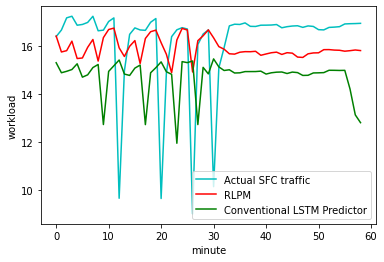

In [74]:
#plt.axis([0,60, 0,17])
x_lables = [0,10,20,30,40,50,60]
plt.plot(real_data_hourly[0], color='c')
plt.plot(predicted_RL[0], color='r')
plt.plot(LSTM_SFC_preds[0], color='g')
plt.legend(['Actual SFC traffic','RLPM','Conventional LSTM Predictor'])
plt.xlabel('minute')
plt.xticks(x_lables)
plt.ylabel('workload')
plt.savefig('RLPMvsLSTM.png', dpi=1000)
plt.show()


RLPMvsGRU - polt

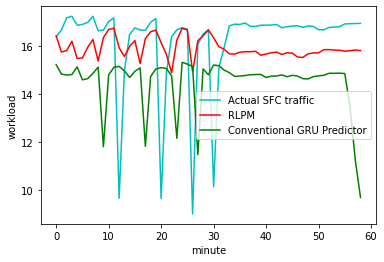

In [75]:
#plt.axis([0,60, 0,17])
x_lables = [0,10,20,30,40,50,60]
plt.plot(real_data_hourly[0], color='c')
plt.plot(predicted_RL[0], color='r')
plt.plot(GRU_SFC_preds[0], color='g')
plt.legend(['Actual SFC traffic','RLPM','Conventional GRU Predictor'])
plt.xlabel('minute')
plt.xticks(x_lables)
plt.ylabel('workload')
plt.savefig('RLPMvsGRU.png', dpi=1000)
plt.show()


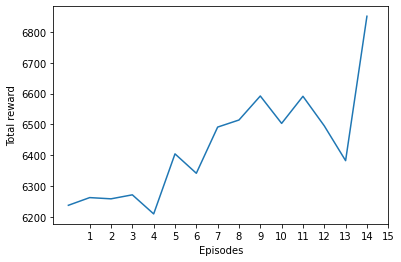

In [76]:
x1_lables = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.plot(total_rewards_train)
plt.xlabel('Episodes')
plt.xticks(x1_lables)
plt.ylabel('Total reward')
plt.savefig('total_rewards2.png', dpi=1000, transparent=True)

Evaluate PMs

In [ ]:
sub1_preds = []
for i in range(len(real_data_hourly[0])):
    pred_SFC_sub1 = sub1.predict(real_data_hourly[0,i:i+4].reshape(1,-1))
    sub1_preds.append(pred_SFC_sub1)

sub1_preds = np.array(sub1_preds).reshape(1,-1)

In [ ]:
sub2_preds = []
for i in range(len(real_data_hourly[0])):
    pred_SFC_sub2 = sub2.predict(real_data_hourly[0,i:i+4].reshape(1,-1))
    sub2_preds.append(pred_SFC_sub2)

sub2_preds = np.array(sub2_preds).reshape(1,-1)

In [ ]:
sub3_preds = []
for i in range(len(real_data_hourly[0])):
    pred_SFC_sub3 = sub3.predict(real_data_hourly[0,i:i+4].reshape(1,-1))
    sub3_preds.append(pred_SFC_sub3)

sub3_preds = np.array(sub3_preds).reshape(1,-1)

In [ ]:
sub4_preds = []
for i in range(len(real_data_hourly[0])):
    pred_SFC_sub4 = sub4.predict(real_data_hourly[0,i:i+4].reshape(1,-1))
    sub4_preds.append(pred_SFC_sub4)

sub4_preds = np.array(sub4_preds).reshape(1,-1)

In [81]:
def MSE(real, predicted):
    mse_total = 0
    for i in range(int(len(real[0]))):
        mse_total += mean_squared_error([real[0,i]], [predicted[0,i]])
    return mse_total

In [82]:
mse1 = MSE(real_data_hourly, sub1_preds)
mse2 = MSE(real_data_hourly, sub2_preds)
mse3 = MSE(real_data_hourly, sub3_preds)
mse4 = MSE(real_data_hourly, sub4_preds)
mse_rl = MSE(real_data_hourly, predicted_RL)
mse_lstm = MSE(real_data_hourly, LSTM_SFC_preds)
mse_gru = MSE(real_data_hourly, GRU_SFC_preds)

In [83]:
print(mse1)
print(mse2)
print(mse3)
print(mse4)
print(mse_rl)
print(mse_lstm)
print(mse_gru)

329.51040322151584
291.5905036960705
374.67725905873783
459.30625862623504
204.0093110133115
389.1436974928553
480.2148427651654


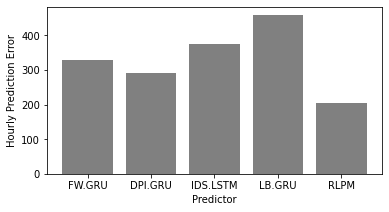

In [84]:
mse_values = [mse1, mse2, mse3, mse4, mse_rl]
models = ['FW.GRU', 'DPI.GRU', 'IDS.LSTM', 'LB.GRU', 'RLPM']

# Define different colors for each bar
#colors = ['blue', 'green', 'orange', 'red', '#800080']
colors = ['gray'] * len(models)

# Create a bar graph
plt.bar(models, mse_values, color=colors)

plt.xlabel('Predictor')
plt.ylabel('Hourly Prediction Error')
#plt.title('Performance Evaluation: RLPM vs Individual PMs')
plt.subplots_adjust(bottom=0.3)

plt.savefig('RLPMvsPMs.png', dpi=1080, bbox_inches='tight')
plt.show()


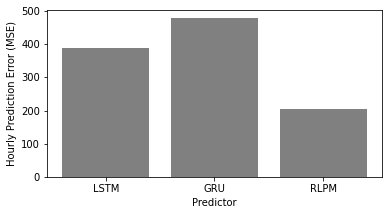

In [85]:
mse_vals = [mse_lstm, mse_gru, mse_rl]
conv_models = ['LSTM', 'GRU', 'RLPM']

colors = ['gray'] * len(conv_models)

# Create a bar graph
plt.bar(conv_models, mse_vals, color=colors)

plt.xlabel('Predictor')
plt.ylabel('Hourly Prediction Error (MSE)')
#plt.title('Performance Evaluation: RLPM vs Individual PMs')
plt.subplots_adjust(bottom=0.3)

plt.savefig('RLPMvsConventionals.png', dpi=1080, bbox_inches='tight')
plt.show()


# Resource Allocation

1- Compare Reactive and Proactive approaches

In [ ]:
def mapping_function2(workload, capacity_range):
    # Define mapping function parameters based on capacity range
    if capacity_range <= 30:
        slope = 1.5
        intercept = 5
    elif 30 < capacity_range <= 40:
        slope = 1.2
        intercept = 8
    elif 40 < capacity_range <= 60:
        slope = 1.1
        intercept = 9
    elif 60 < capacity_range <= 70:
        slope = 1.05
        intercept = 9.5
    elif 70 < capacity_range <= 80:
        slope = 1
        intercept = 10
    else:
        # For capacities above 80, use a default slope and intercept
        slope = 0.9
        intercept = 11

    # Apply the linear mapping function
    required_cores = slope * workload + intercept

    # Ensure that the number of cores is within the specified range [0, capacity_range]
    required_cores = max(0, min(capacity_range, int(required_cores)))
    
    return required_cores


# Example usage:
workload_values = [10, 20, 30]

for workload in workload_values:
    for capacity_range in [30, 50, 80]:
        print(mapping_function2(workload, capacity_range))


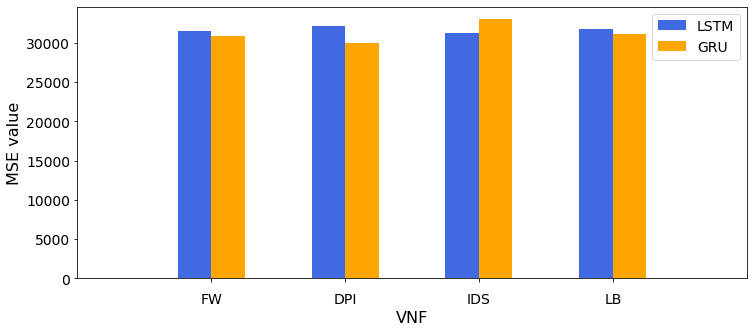

In [94]:
plotdata = pd.DataFrame({
    "LSTM": [31511, 32112, 31278, 31755],
    "GRU" : [30856, 30004, 33000, 31196]
}, index=["FW", "DPI", "IDS", "LB"])

# plot configuration
ax = plotdata.plot(kind="bar", figsize=(12, 5), color=['#4169E1','#FFA500'], width=0.5,fontsize=14) #00CED1, 00BFFF, 1E90FF

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# set the spacing between the x-axis labels
ax.xaxis.set_tick_params(pad=10) # adjust this value based on your requirements

# Adjust the xlim to add space on the right of the bars
ax.set_xlim(-1, len(plotdata.index))
ax.patch.set_facecolor('white')
#ax.set_facecolor('white')

plt.xlabel("VNF", fontsize=16)
plt.ylabel("MSE value", fontsize=16)

# add legend to the plot
ax.legend(fontsize=14, loc='upper right')

# save the plot
plt.savefig('Comapre_models_accuracy_for_different_VNFS.png', dpi=1080, bbox_inches='tight')

# display the plot
plt.show()

2- Copmare MILP and Heuristic strategies

Reduction in Resource Utilization due to Proactive Approach: 2.07%


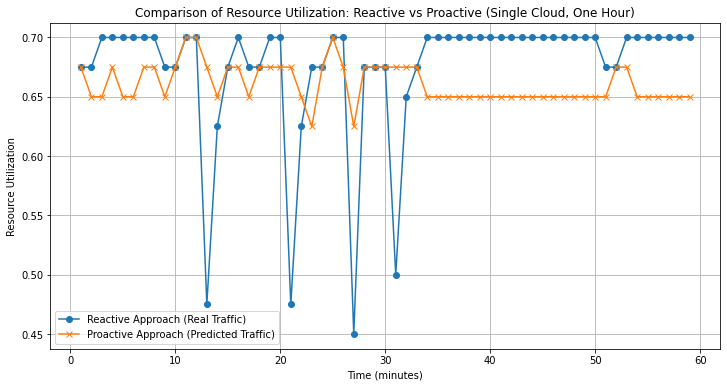

In [205]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming a single cloud with 100 available cores
available_cores_per_cloud = 40
# Initialize RU arrays
ru_reactive = np.zeros(len(real_data_hourly))
ru_proactive = np.zeros(len(predicted_RL_hourly))

# Calculate RU for reactive (real traffic) and proactive (predicted traffic)
for t in range(len(real_data_hourly)):
    # Calculate allocated cores for reactive approach
    allocated_cores_reactive = mapping_function2(real_data_hourly[t], available_cores_per_cloud)
    ru_reactive[t] = allocated_cores_reactive / available_cores_per_cloud
    
    # Calculate allocated cores for proactive approach
    allocated_cores_proactive = mapping_function2(predicted_RL_hourly[t], available_cores_per_cloud)
    ru_proactive[t] = allocated_cores_proactive / available_cores_per_cloud

# Calculate average RU over time for each approach
average_ru_reactive = np.mean(ru_reactive)
average_ru_proactive = np.mean(ru_proactive)

# Calculate reduction percentage in RU
reduction_percentage = (average_ru_reactive - average_ru_proactive) / average_ru_reactive * 100

# Print reduction percentage
print(f"Reduction in Resource Utilization due to Proactive Approach: {reduction_percentage:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))

# Line plot for RU
plt.plot(range(1, 60), ru_reactive[:60], label='Reactive Approach (Real Traffic)', marker='o')
plt.plot(range(1, 60), ru_proactive[:60], label='Proactive Approach (Predicted Traffic)', marker='x')

plt.xlabel('Time (minutes)')
plt.ylabel('Resource Utilization')
plt.title('Comparison of Resource Utilization: Reactive vs Proactive (Single Cloud, One Hour)')
plt.legend()
plt.grid(True)
plt.show()


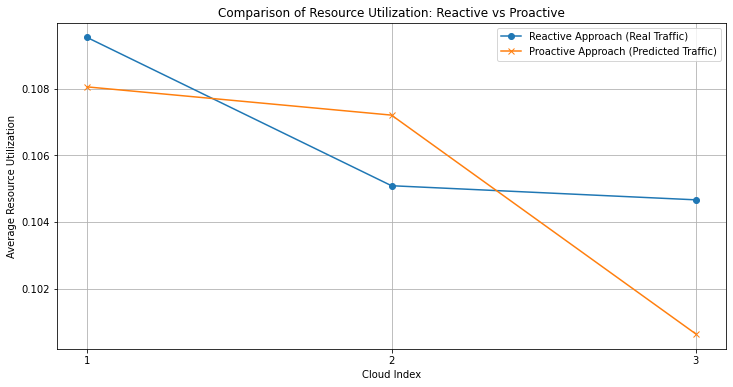

In [162]:
# Assuming 5 clouds, each with 100 available cores
num_clouds = 3
available_cores_per_cloud = 80

# Initialize RU arrays
ru_reactive = np.zeros((num_clouds, len(real_data_hourly)))
ru_proactive = np.zeros((num_clouds, len(predicted_RL_hourly)))

# Distribute the traffic across the clouds (e.g., evenly)
def distribute_traffic(traffic, num_clouds):
    return np.array_split(traffic, num_clouds)

# Distribute real and predicted traffic
real_traffic_splits = distribute_traffic(real_data_hourly, num_clouds)
predicted_traffic_splits = distribute_traffic(predicted_RL_hourly, num_clouds)

# Calculate RU for reactive (real traffic) and proactive (predicted traffic)
for cloud_idx in range(num_clouds):
    for t in range(len(real_traffic_splits[cloud_idx])):
        # Calculate allocated cores for reactive approach
        allocated_cores_reactive = mapping_function2(real_traffic_splits[cloud_idx][t], available_cores_per_cloud)
        ru_reactive[cloud_idx, t] = allocated_cores_reactive / available_cores_per_cloud
        
        # Calculate allocated cores for proactive approach
        allocated_cores_proactive = mapping_function2(predicted_traffic_splits[cloud_idx][t], available_cores_per_cloud)
        ru_proactive[cloud_idx, t] = allocated_cores_proactive / available_cores_per_cloud

# Calculate average RU over time for each approach
average_ru_reactive = np.mean(ru_reactive, axis=1)
average_ru_proactive = np.mean(ru_proactive, axis=1)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_clouds + 1), average_ru_reactive, label='Reactive Approach (Real Traffic)', marker='o')
plt.plot(range(1, num_clouds + 1), average_ru_proactive, label='Proactive Approach (Predicted Traffic)', marker='x')

plt.xlabel('Cloud Index')
plt.ylabel('Average Resource Utilization')
plt.title('Comparison of Resource Utilization: Reactive vs Proactive')
plt.xticks(range(1, num_clouds + 1))  # Set x-axis ticks to match cloud indices
plt.legend()
plt.grid(True)
plt.show()


Average RU (Reactive Approach): 0.15
Average RU (Proactive Approach): 0.15
Proactive approach results in a 1.71% reduction in resource utilization compared to the reactive approach.


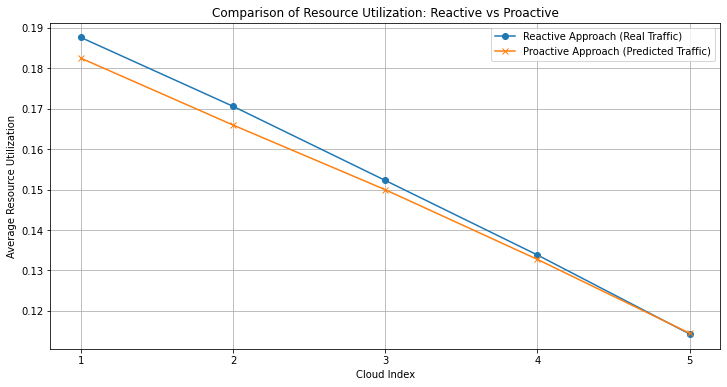

In [218]:
# Assuming 3 clouds, each with 80 available cores
num_clouds = 5
available_cores_per_cloud = 30

# Initialize RU arrays
ru_reactive = np.zeros((num_clouds, len(real_data)))
ru_proactive = np.zeros((num_clouds, len(predicted_RL)))

# Distribute the traffic across the clouds (e.g., evenly)
def distribute_traffic(traffic, num_clouds):
    return np.array_split(traffic, num_clouds)

# Distribute real and predicted traffic
real_traffic_splits = distribute_traffic(real_data, num_clouds)
predicted_traffic_splits = distribute_traffic(predicted_RL, num_clouds)

# Calculate RU for reactive (real traffic) and proactive (predicted traffic)
for cloud_idx in range(num_clouds):
    for t in range(len(real_traffic_splits[cloud_idx])):
        # Calculate allocated cores for reactive approach
        allocated_cores_reactive = mapping_function2(real_traffic_splits[cloud_idx][t], available_cores_per_cloud)
        ru_reactive[cloud_idx, t] = allocated_cores_reactive / available_cores_per_cloud
        
        # Calculate allocated cores for proactive approach
        allocated_cores_proactive = mapping_function2(predicted_traffic_splits[cloud_idx][t], available_cores_per_cloud)
        ru_proactive[cloud_idx, t] = allocated_cores_proactive / available_cores_per_cloud

# Calculate average RU over time for each approach
average_ru_reactive = np.mean(ru_reactive, axis=1)
average_ru_proactive = np.mean(ru_proactive, axis=1)

# Calculate total average RU across all clouds
average_ru_reactive_total = np.mean(average_ru_reactive)
average_ru_proactive_total = np.mean(average_ru_proactive)

# Calculate the percentage reduction in RU
percentage_reduction = (1 - (average_ru_proactive_total / average_ru_reactive_total)) * 100

# Print results
print(f"Average RU (Reactive Approach): {average_ru_reactive_total:.2f}")
print(f"Average RU (Proactive Approach): {average_ru_proactive_total:.2f}")
print(f"Proactive approach results in a {percentage_reduction:.2f}% reduction in resource utilization compared to the reactive approach.")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_clouds + 1), average_ru_reactive, label='Reactive Approach (Real Traffic)', marker='o')
plt.plot(range(1, num_clouds + 1), average_ru_proactive, label='Proactive Approach (Predicted Traffic)', marker='x')

plt.xlabel('Cloud Index')
plt.ylabel('Average Resource Utilization')
plt.title('Comparison of Resource Utilization: Reactive vs Proactive')
plt.xticks(range(1, num_clouds + 1))  # Set x-axis ticks to match cloud indices
plt.legend()
plt.grid(True)
plt.show()


resduction:  [1.06171201 1.06171201 1.06171201] 


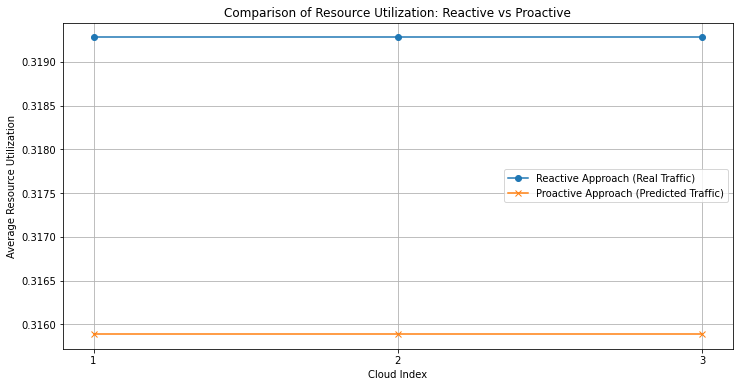

In [225]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 5 clouds, each with 100 available cores
num_clouds = 3
available_cores_per_cloud = 80

# Initialize RU arrays
ru_reactive = np.zeros((num_clouds, len(real_data_hourly)))
ru_proactive = np.zeros((num_clouds, len(predicted_RL_hourly)))

# Distribute the traffic across the clouds (dynamically based on capacity)
def distribute_traffic_dynamically(traffic, num_clouds, available_cores_per_cloud):
    cloud_loads = np.zeros(num_clouds)
    allocation = np.zeros((num_clouds, len(traffic)))
    
    for t in range(len(traffic)):
        # Calculate required cores for each cloud
        required_cores = np.zeros(num_clouds)
        for cloud_idx in range(num_clouds):
            required_cores[cloud_idx] = mapping_function2(traffic[t], available_cores_per_cloud)
        
        # Distribute traffic based on available cores
        for cloud_idx in range(num_clouds):
            allocated_cores = min(required_cores[cloud_idx], available_cores_per_cloud - cloud_loads[cloud_idx])
            allocation[cloud_idx, t] = allocated_cores
            cloud_loads[cloud_idx] += allocated_cores
        
        # Reset cloud loads for the next time step
        cloud_loads = np.clip(cloud_loads - allocation[:, t], 0, available_cores_per_cloud)
    
    return allocation

# Distribute real and predicted traffic
real_traffic_splits = distribute_traffic_dynamically(real_data_hourly, num_clouds, available_cores_per_cloud)
predicted_traffic_splits = distribute_traffic_dynamically(predicted_RL_hourly, num_clouds, available_cores_per_cloud)

# Calculate RU for reactive (real traffic) and proactive (predicted traffic)
for cloud_idx in range(num_clouds):
    for t in range(len(real_data_hourly)):
        allocated_cores_reactive = real_traffic_splits[cloud_idx, t]
        ru_reactive[cloud_idx, t] = allocated_cores_reactive / available_cores_per_cloud
        
        allocated_cores_proactive = predicted_traffic_splits[cloud_idx, t]
        ru_proactive[cloud_idx, t] = allocated_cores_proactive / available_cores_per_cloud

# Calculate average RU over time for each approach
average_ru_reactive = np.mean(ru_reactive, axis=1)
average_ru_proactive = np.mean(ru_proactive, axis=1)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_clouds + 1), average_ru_reactive, label='Reactive Approach (Real Traffic)', marker='o')
plt.plot(range(1, num_clouds + 1), average_ru_proactive, label='Proactive Approach (Predicted Traffic)', marker='x')

plt.xlabel('Cloud Index')
plt.ylabel('Average Resource Utilization')
plt.title('Comparison of Resource Utilization: Reactive vs Proactive')
plt.xticks(range(1, num_clouds + 1))  # Set x-axis ticks to match cloud indices
plt.legend()
plt.grid(True)
plt.show()


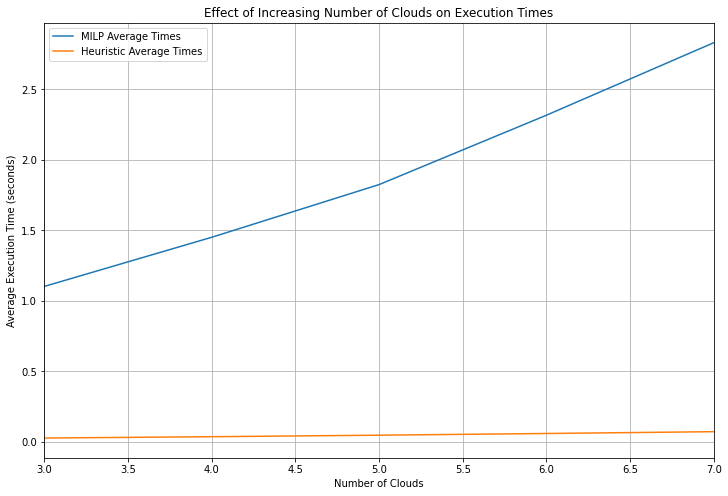

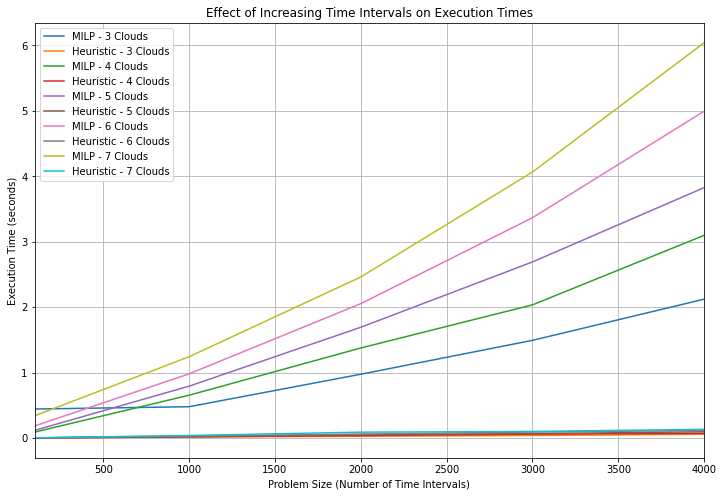

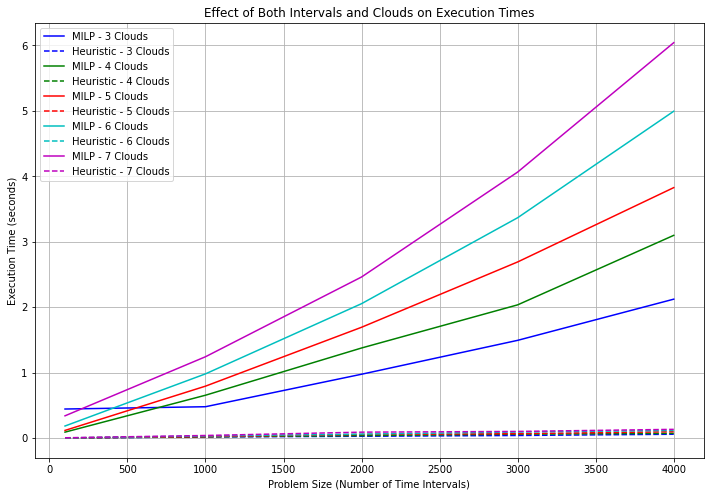

In [226]:
# Plot the results

## First plot: Effect of increasing number of clouds
plt.figure(figsize=(12, 8))
clouds = list(cloud_configurations.keys())
milp_avg_times_clouds = [np.mean(milp_times[num_clouds]) for num_clouds in clouds]
heuristic_avg_times_clouds = [np.mean(heuristic_times[num_clouds]) for num_clouds in clouds]

plt.plot(clouds, milp_avg_times_clouds, label='MILP Average Times')
plt.plot(clouds, heuristic_avg_times_clouds, label='Heuristic Average Times')

plt.xlabel('Number of Clouds')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Effect of Increasing Number of Clouds on Execution Times')
plt.legend()
plt.grid(True)

# Set the range of the x-axis
plt.xlim(min(clouds), max(clouds))  # Adjust as needed

plt.savefig('effect_of_clouds.png', dpi=1080, bbox_inches='tight')
plt.show()


# Second plot: Effect of increasing time intervals
plt.figure(figsize=(12, 8))
for num_clouds in cloud_configurations.keys():
    plt.plot(problem_sizes, milp_times[num_clouds], label=f'MILP - {num_clouds} Clouds')
    plt.plot(problem_sizes, heuristic_times[num_clouds], label=f'Heuristic - {num_clouds} Clouds')

plt.xlabel('Problem Size (Number of Time Intervals)')
plt.ylabel('Execution Time (seconds)')
plt.title('Effect of Increasing Time Intervals on Execution Times')
plt.legend()
plt.grid(True)
plt.xlim(min(problem_sizes), max(problem_sizes)) 
plt.savefig('effect_of_time_intervals.png', dpi=1080, bbox_inches='tight')
plt.show()

# Combined plot: Effect of both intervals and clouds
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for idx, num_clouds in enumerate(cloud_configurations.keys()):
    ax.plot(problem_sizes, milp_times[num_clouds], color=colors[idx % len(colors)], linestyle='-', label=f'MILP - {num_clouds} Clouds')
    ax.plot(problem_sizes, heuristic_times[num_clouds], color=colors[idx % len(colors)], linestyle='--', label=f'Heuristic - {num_clouds} Clouds')

ax.set_xlabel('Problem Size (Number of Time Intervals)')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Effect of Both Intervals and Clouds on Execution Times')
ax.legend()
ax.grid(True)
plt.savefig('combined_effects.png', dpi=1080, bbox_inches='tight')
plt.show()